In [1]:
import glob
import os
import pickle
import numpy as np
import pandas as pd
# import scanpy as sc
import tqdm
import gc
import os
import numpy as np
import pandas as pd
# import scanpy as sc
import glob
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import issparse

def get_MI(adata1, adata2, gene_list, spatial_matrix):
    moran_scores = []
    adata1.obsm["gpd"] = gpd.GeoDataFrame(adata1.obs, geometry=gpd.points_from_xy(spatial_matrix[:, 0], spatial_matrix[:, 1]))
    print("Calculate Moran's I score...")
    for gene in tqdm.tqdm(gene_list):
        x = adata1.to_df()[gene].values
        y = adata2.to_df()[gene].values
        w = Queen.from_dataframe(adata1.obsm["gpd"])
        moran_bv = Moran_BV(y, x, w)
        moran_scores.append(moran_bv.I)
    return moran_scores
    
def get_R(data1,data2,dim=1,func=pearsonr):
    adata1=data1.X
    adata2=data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata2 = adata2.toarray() if issparse(adata2) else adata2
    
    r1,p1=[],[]
    for g in range(data1.shape[dim]):
        if dim==1:
            r,pv=func(adata1[:,g],adata2[:,g], alternative='greater')
        elif dim==0:
            r,pv=func(adata1[g,:],adata2[g,:], alternative='greater')
        r1.append(r)
        p1.append(pv)
    r1=np.array(r1)
    p1=np.array(p1)
    return r1,p1

def get_ssim(data1, data2, num_breaks=None):
    """
    Some info about SSIM computation.
    data1: the ground truth data
    data2: the predicted data
    dim: the dimension to calculate the SSIM. If the dim = 1, calculate the SSIM at gene-wise, otherwise calculate the SSIM at spot-wise.
    """
    adata1 = data1.X
    adata2 = data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata1 = adata1.toarray() if issparse(adata1) else adata1
    adata2 = adata2.toarray() if issparse(adata2) else adata2

    SSIM = []
    for g in range(adata1.shape[1]):
        x = adata1[:,g]
        y = adata2[:,g]
        # Normalize the arrays if their maximum values are not zero
        x = x if np.max(x) == 0 else x / np.max(x)
        y = y if np.max(y) == 0 else y / np.max(y)  
    
        if num_breaks:
            # Discretize the normalized arrays into 'num_breaks' bins
            x = np.digitize(x, np.linspace(0, 1, num_breaks), right=False) - 1
            y = np.digitize(y, np.linspace(0, 1, num_breaks), right=False) - 1
            
            # Constants used in SSIM calculation
            C1 = (0.01 * (num_breaks - 1))**2
            C2 = (0.03 * (num_breaks - 1))**2
        else:
            C1 = (0.01)**2
            C2 = (0.03)**2
        
        mux = np.mean(x)
        muy = np.mean(y) 
        sigxy = np.cov(x, y)[0, 1]
        sigx = np.var(x)
        sigy = np.var(y)
        
        ssim = ((2 * mux * muy + C1) * (2 * sigxy + C2)) / ((mux**2 + muy**2 + C1) * (sigx + sigy + C2))
        SSIM.append(ssim)
        assert -1 <= ssim <= 1, "SSIM should be within the valid range [-1, 1]"
        
    return SSIM

def get_cosine(data1, data2):
    # Convert the anndata to numpy array
    adata1=data1.X.T
    adata2=data2.X.T
    # Calculate the consine similarity at gene wise
    cosine_sim = cosine_similarity(adata1, adata2)
    # Take the diag of similarity matrix
    cosine_score = np.diag(cosine_sim)
    return cosine_score

def make_res(source_dataset, target_dataset, methods, names, ensemble=True):
    # RESULTS_DIR = "../Results/Generalizability"
    # SUMMARY_DIR = "../Results/Summary/Generalizability"
    RESULTS_DIR = "../Results/Generalizability"
    SUMMARY_DIR = "../Results/Summary/Generalizability2"


    if ensemble:
        model_no = "mean"
    else:
        model_no = 0

    for method in tqdm.tqdm(methods):
        for name in names:
            gc.collect()
            file_path = os.path.join(RESULTS_DIR, f"{source_dataset}_{target_dataset}", "ensemble", f"pred_{method}_{source_dataset}_{target_dataset}_{name}_{model_no}.h5ad")

            if os.path.exists(file_path):
                data1 = sc.read_h5ad(os.path.join(RESULTS_DIR, f"{source_dataset}_{target_dataset}", f"gt_{method}_{source_dataset}_{target_dataset}_{name}.h5ad"))
                data2 = sc.read_h5ad(file_path)
                spatial_matrix = np.load(os.path.join(RESULTS_DIR, f"{source_dataset}_{target_dataset}", f"spatial_loc_{method}_{source_dataset}_{target_dataset}_{name}_func.npy"))
                data2.var_names = data1.var_names
                pcc, PCC_PValue = get_R(data1, data2, dim=1, func=pearsonr)
                spc, SPC_PValue = get_R(data1, data2, dim=1, func=spearmanr)
                ssim_score = get_ssim(data1, data2)
                cosine_score = get_cosine(data1, data2)
                MI = get_MI(data1, data2, list(data1.var_names), spatial_matrix)

                PCC_BC_Visium = {
                    "Gene": list(data1.var_names),
                    "Pearson correlation": pcc,
                    "PCC_PValue": PCC_PValue,
                    "Spearmanr correlation": spc,
                    "SPC_PValue": SPC_PValue,
                    "SSIM_Score": ssim_score,
                    "Cosine_Score": cosine_score,
                    "MI": MI,
                    "Slides": [name] * len(pcc),
                    "Dataset": [f"{source_dataset}_{target_dataset}"] * len(pcc),
                    "Method": [method] * len(pcc),
                }

                pcc_bc_visium = pd.DataFrame(PCC_BC_Visium)
                summary_dir = os.path.join(SUMMARY_DIR, f"{source_dataset}_{target_dataset}")

                if not os.path.exists(summary_dir):
                    os.mkdir(summary_dir)

                pcc_bc_visium.to_csv(os.path.join(RESULTS_DIR, f"{source_dataset}_{target_dataset}", f"{method}_{source_dataset}_{target_dataset}_{name}_nonMI.csv"))
            else:
                print(f"The file {file_path} does not exist. Skipping.")

    print("Organize the results into summary file!")
    res = glob.glob(os.path.join(RESULTS_DIR, f"{source_dataset}_{target_dataset}", "*_nonMI.csv"))
    df = pd.concat([pd.read_csv(i, index_col=[0]) for i in res])

    summary_dir = os.path.join(SUMMARY_DIR, f"{source_dataset}_{target_dataset}")

    if not os.path.exists(summary_dir):
        os.mkdir(summary_dir)

    df.to_csv(os.path.join(SUMMARY_DIR, f"{source_dataset}_{target_dataset}_summary_nonMI_{model_no}.csv"))
    return df

def top_predictable_genes(df_results: pd.DataFrame, dataset: str, method: str, num: int = 5) -> pd.DataFrame:
    """
    Extracts the top predictable genes based on Pearson correlation for a specific method and dataset.

    Parameters:
        - df_results (pd.DataFrame): The DataFrame containing the results from the make_res function.
        - dataset (str): The dataset name.
        - method (str): The method name.
        - num (int, optional): The number of top predictable genes or "pos" for all positive Pearson correlation values.

    Returns:
        pd.DataFrame: DataFrame containing the top predictable genes and related statistics.
    """
    df = df_results[df_results["Method"] == method]

    if num == "pos":
        top_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(
            ['median', 'mean', 'max', 'min', 'std']
        ).sort_values(by=('Pearson correlation', 'median'), ascending=False)
    else:
        top_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(
            ['median', 'mean', 'max', 'min', 'std']
        ).sort_values(by=('Pearson correlation', 'median'), ascending=False).head(num)

    top_genes = list(top_df.index)

    # Calculate the number of consistent samples for each top gene
    num_pos = [df[df["Gene"] == g]['Pearson correlation'].gt(0).sum() for g in top_genes]

    # Create the final DataFrame with relevant columns
    top_df["Number of consistent samples"] = num_pos
    top_df["Method"] = method
    top_df["Dataset"] = dataset
    top_df = top_df[[('Method', ''), ('Dataset', ''), ('Number of consistent samples', ''),
                     ('Pearson correlation', 'mean'), ('Pearson correlation', 'median'),
                     ('Pearson correlation', 'min'), ('Pearson correlation', 'max'),
                     ('Pearson correlation', 'std')]]

    return top_df


In [3]:
methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]



## Skin_Melanoma2BC_visium

In [4]:
import geopandas as gpd
from libpysal.weights.contiguity import Queen
from sklearn.metrics.pairwise import cosine_similarity
from libpysal.weights.contiguity import Queen
from splot.esda import moran_scatterplot, lisa_cluster
from esda.moran import Moran, Moran_Local
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation


In [2]:
source_dataset = "Skin_Melanoma"
target_dataset = "BC_visium"

if target_dataset == "Kidney_visium":
    names = ["A", "B", "C", "D", "Visium14_C", "Visium14_D"]
elif target_dataset == "BC_Her2ST":
    names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/{target_dataset}/gt_stimage_{target_dataset}_reinhard*h5ad")]))
elif target_dataset == "BC_visium":
    names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
elif target_dataset == "Skin_Melanoma":
    names = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
elif target_dataset == "Skin_cSCC":
    names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
elif target_dataset == "Liver_visium":
    names = ["C73_A1_VISIUM", "C73_B1_VISIUM", "C73_C1_VISIUM", "C73_D1_VISIUM"]
    
Methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]


df = make_res(source_dataset, target_dataset, Methods, names, ensemble=True);


## SkincSCC2Skin_Melanoma

In [ ]:
source_dataset = "Skin_cSCC"
target_dataset = "Skin_Melanoma"

if target_dataset == "Kidney_visium":
    names = ["A", "B", "C", "D", "Visium14_C", "Visium14_D"]
elif target_dataset == "BC_Her2ST":
    names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/{dataset_name}/gt_stimage_{dataset_name}_reinhard*h5ad")]))
elif target_dataset == "BC_visium":
    names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
elif target_dataset == "Skin_Melanoma":
    names = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
elif target_dataset == "Skin_cSCC":
    names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
elif target_dataset == "Liver_visium":
    names = ["C73_A1_VISIUM", "C73_B1_VISIUM", "C73_C1_VISIUM", "C73_D1_VISIUM"]
    
Methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]

df = make_res(source_dataset, target_dataset, Methods, names, ensemble=True)


## Skin_cSCC_BC_Her2ST

In [3]:
source_dataset = "Skin_cSCC"
target_dataset = "BC_Her2ST"

if target_dataset == "Kidney_visium":
    names = ["A", "B", "C", "D", "Visium14_C", "Visium14_D"]
elif target_dataset == "BC_Her2ST":
    names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/{target_dataset}/gt_stimage_{target_dataset}_reinhard*h5ad")]))
elif target_dataset == "BC_visium":
    names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
elif target_dataset == "Skin_Melanoma":
    names = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
elif target_dataset == "Skin_cSCC":
    names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
elif target_dataset == "Liver_visium":
    names = ["C73_A1_VISIUM", "C73_B1_VISIUM", "C73_C1_VISIUM", "C73_D1_VISIUM"]
    
Methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]

df = make_res(source_dataset, target_dataset, Methods, names, ensemble=True)


## Skin_Melanoma2Skin_cSCC

In [4]:
source_dataset = "Skin_Melanoma"
target_dataset = "Skin_cSCC"

if target_dataset == "Kidney_visium":
    names = ["A", "B", "C", "D", "Visium14_C", "Visium14_D"]
elif target_dataset == "BC_Her2ST":
    names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/{target_dataset}/gt_stimage_{target_dataset}_reinhard*h5ad")]))
elif target_dataset == "BC_visium":
    names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
elif target_dataset == "Skin_Melanoma":
    names = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
elif target_dataset == "Skin_cSCC":
    names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
elif target_dataset == "Liver_visium":
    names = ["C73_A1_VISIUM", "C73_B1_VISIUM", "C73_C1_VISIUM", "C73_D1_VISIUM"]
    
Methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]

df = make_res(source_dataset, target_dataset, Methods, names, ensemble=True)


## BC_visium2Her2ST

In [ ]:
source_dataset = "BC_visium"
target_dataset = "BC_Her2ST"

if target_dataset == "Kidney_visium":
    names = ["A", "B", "C", "D", "Visium14_C", "Visium14_D"]
elif target_dataset == "BC_Her2ST":
    names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/{target_dataset}/gt_stimage_{target_dataset}_reinhard*h5ad")]))
elif target_dataset == "BC_visium":
    names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
elif target_dataset == "Skin_Melanoma":
    names = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
elif target_dataset == "Skin_cSCC":
    names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
elif target_dataset == "Liver_visium":
    names = ["C73_A1_VISIUM", "C73_B1_VISIUM", "C73_C1_VISIUM", "C73_D1_VISIUM"]
    
Methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]

df = make_res(source_dataset, target_dataset, Methods, names, ensemble=True)


# Her2ST2BC_visium

In [ ]:
source_dataset = "BC_Her2ST"
target_dataset = "BC_visium"

if target_dataset == "Kidney_visium":
    names = ["A", "B", "C", "D", "Visium14_C", "Visium14_D"]
elif target_dataset == "BC_Her2ST":
    names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/{target_dataset}/gt_stimage_{target_dataset}_reinhard*h5ad")]))
elif target_dataset == "BC_visium":
    names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
elif target_dataset == "Skin_Melanoma":
    names = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
elif target_dataset == "Skin_cSCC":
    names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
elif target_dataset == "Liver_visium":
    names = ["C73_A1_VISIUM", "C73_B1_VISIUM", "C73_C1_VISIUM", "C73_D1_VISIUM"]
    
Methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]

df = make_res(source_dataset, target_dataset, Methods, names, ensemble=True)


# Visiualize the results

In [4]:
df_OOD = pd.concat(pd.read_csv(r, index_col=[0]) for r in glob.glob("../Results/Summary/Generalizability4/*_*_*_*_summary_nonMI_mean.csv"))

In [5]:
df_OOD.rename(columns={"MI": "Moran'I_Score"}, inplace=True)

In [6]:
target_dataset = 'BC_Her2ST'
names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/{target_dataset}/gt_stimage_{target_dataset}_reinhard*h5ad")]))
# names

In [7]:
df_OOD[df_OOD['Dataset'] == 'Skin_cSCC_BC_Her2ST']

,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Moran'I_Score,Slides,Dataset,Method
0,PDIA4,0.197910,0.003871,0.147524,0.024062,0.192308,0.813488,0.501769,C4,Skin_cSCC_BC_Her2ST,stnet
1,CD48,-0.016518,0.587094,-0.006928,0.536769,-0.004667,0.295520,0.781667,C4,Skin_cSCC_BC_Her2ST,stnet
2,TAF1,0.279544,0.000072,0.292441,0.000034,0.170582,0.335986,0.939955,C4,Skin_cSCC_BC_Her2ST,stnet
3,ITGB2,-0.075079,0.841752,-0.053150,0.760719,0.022044,-0.128350,0.156644,C4,Skin_cSCC_BC_Her2ST,stnet
4,NFATC1,-0.120500,0.946442,-0.125223,0.953027,-0.057218,-0.059718,-0.370629,C4,Skin_cSCC_BC_Her2ST,stnet
...,...,...,...,...,...,...,...,...,...,...,...
1118,RNASE6,0.027449,0.323120,0.048705,0.207610,0.002918,0.193017,0.156414,B4,Skin_cSCC_BC_Her2ST,hist2st
1119,DNASE1L1,-0.145204,0.992667,-0.152710,0.994887,-0.014603,0.308884,-1.147108,B4,Skin_cSCC_BC_Her2ST,hist2st
1120,LAG3,0.007802,0.448110,-0.031439,0.700464,0.006964,0.367779,-0.040090,B4,Skin_cSCC_BC_Her2ST,hist2st
1121,CXCR5,-0.231973,0.999958,-0.243999,0.999983,-0.025046,0.153700,-2.668559,B4,Skin_cSCC_BC_Her2ST,hist2st


In [8]:
# Define mapping dictionaries for model and dataset names
model_mapping = {
    'deeppt': "DeepPT",
    'histogene': "HisToGene",
    'His2gene': "HisToGene",
    'stnet': "STnet",
    'hist2st': "Hist2ST",
    'stimage': "STimage",
    'bleep': "BLEEP",
    'deepspace': "DeepSpaCE"
}

# Replace model and dataset names in the DataFrame
df_OOD.replace({'Method': model_mapping,}, inplace=True)

# Define the order for Dataset and Method columns
dataset_order = ['BC_Her2ST_BC_visium', 'BC_visium_BC_Her2ST', 'Skin_cSCC_Skin_Melanoma', 'Skin_cSCC_BC_Her2ST', 'Skin_Melanoma_BC_visium', 'Skin_Melanoma_Skin_cSCC']
method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']

# Use pd.Categorical directly during DataFrame creation
df_OOD['Dataset'] = pd.Categorical(df_OOD['Dataset'], categories=dataset_order, ordered=True)
df_OOD['Method'] = pd.Categorical(df_OOD['Method'], categories=method_order, ordered=True)


In [9]:
# df_OOD = pd.read_csv("../Results/Summary/Generalizability/OOD_summary_nonMI_ensemble.csv")
df_ID = pd.read_csv("../Results/Summary/ID_func_metrics.csv")
df_ID = df_ID[df_ID["Dataset"].isin(["BC_Her2ST", "BC_Visium", "Skin_Melanoma", "Skin_cSCC"])]
df2 = pd.concat([df_ID, df_OOD])

In [9]:
df2.Dataset.unique()

array(['BC_Her2ST', 'BC_Visium', 'Skin_Melanoma', 'Skin_cSCC',
       'Skin_cSCC_Skin_Melanoma', 'Skin_cSCC_BC_Her2ST',
       'Skin_Melanoma_BC_visium', 'Skin_Melanoma_Skin_cSCC'], dtype=object)

In [26]:
df2[df2['Dataset'] == 'Skin_cSCC-OOD']

,Unnamed: 0,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Moran'I_Score,Slides,Dataset,Method,MI
0,NaN,NaN,C1QB,-0.033963,0.865935,-0.043351,0.921278,0.006575,0.131071,NaN,P9_ST_rep2,Skin_cSCC-OOD,DeepSpaCE,-0.001556
1,NaN,NaN,ITGB7,-0.014295,0.679385,-0.010634,0.635563,0.017267,0.026645,NaN,P9_ST_rep2,Skin_cSCC-OOD,DeepSpaCE,-0.016148
2,NaN,NaN,PDGFB,-0.026616,0.807229,-0.023256,0.775820,0.012509,0.104104,NaN,P9_ST_rep2,Skin_cSCC-OOD,DeepSpaCE,-0.023980
3,NaN,NaN,PDGFRA,-0.017543,0.716295,-0.000268,0.503479,0.013266,0.092634,NaN,P9_ST_rep2,Skin_cSCC-OOD,DeepSpaCE,-0.011715
4,NaN,NaN,EIF4A2,-0.063526,0.980904,-0.065281,0.983421,-0.015762,0.221867,NaN,P9_ST_rep2,Skin_cSCC-OOD,DeepSpaCE,-0.041935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101,NaN,NaN,BAX,-0.069694,0.958540,-0.066968,0.952142,-0.008180,0.168945,NaN,P10_ST_rep2,Skin_cSCC-OOD,HisToGene,-0.025273
1102,NaN,NaN,SHC3,-0.037349,0.823410,-0.027336,0.751558,-0.000843,0.115090,NaN,P10_ST_rep2,Skin_cSCC-OOD,HisToGene,0.004788
1103,NaN,NaN,ZC3H12A,0.034899,0.192837,0.033844,0.200104,0.009998,0.258671,NaN,P10_ST_rep2,Skin_cSCC-OOD,HisToGene,-0.009999
1104,NaN,NaN,BMPR1B,-0.027343,0.751617,-0.035346,0.810195,0.000097,0.061851,NaN,P10_ST_rep2,Skin_cSCC-OOD,HisToGene,-0.036461


In [10]:
dataset_mapping = {
    'BC_Her2ST': "BC_Her2ST-ID",
    'Skin_cSCC': "Skin_cSCC-ID",
    'Skin_Melanoma': "Skin_Melanoma-ID",
    'BC_Visium': "BC_Visium-ID",
    'Skin_cSCC_BC_Her2ST': "BC_Her2ST-OOD",
    # 'BC_visium_BC_Her2ST': "BC_Her2ST-OOD2",
    'Skin_Melanoma_Skin_cSCC': "Skin_cSCC-OOD",
    'Skin_cSCC_Skin_Melanoma': "Skin_Melanoma-OOD",
    'Skin_Melanoma_BC_visium': "BC_Visium-OOD",
    # 'BC_Her2ST_BC_visium': "BC_Visium-OOD2",
}
df2.replace({'Dataset': dataset_mapping,}, inplace=True)


In [11]:
dataset_order = ['BC_Her2ST-ID', 'BC_Her2ST-OOD', 'BC_visium_BC_Her2ST', 'BC_Visium-ID', 'BC_Visium-OOD', 'BC_Her2ST_BC_visium', 'Skin_Melanoma-ID',  'Skin_Melanoma-OOD', 'Skin_cSCC-ID', 'Skin_cSCC-OOD'] # 'BC_Her2ST-OOD2', 
method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']

df2['Dataset'] = pd.Categorical(df2['Dataset'], categories=dataset_order, ordered=True)
df2['Method'] = pd.Categorical(df2['Method'], categories=method_order, ordered=True)


In [12]:
df3 = df2[df2['Dataset'].isin(['BC_Her2ST-ID', 'BC_Her2ST_BC_visium', 'BC_Visium-ID', 'BC_visium_BC_Her2ST'])]
dataset_order = ['BC_Her2ST-ID', 'BC_Her2ST_BC_visium', 'BC_Visium-ID', 'BC_visium_BC_Her2ST']
df3['Dataset'] = pd.Categorical(df3['Dataset'], categories=dataset_order, ordered=True)


/scratch/temp/11974052/ipykernel_3215688/3765767978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Dataset'] = pd.Categorical(df3['Dataset'], categories=dataset_order, ordered=True)


In [16]:
df3.Dataset.unique()

['BC_Her2ST-ID', 'BC_Visium-ID']
Categories (4, object): ['BC_Her2ST-ID' < 'BC_Her2ST_BC_visium' < 'BC_Visium-ID' < 'BC_visium_BC_Her2ST']

In [13]:
df3

,Unnamed: 0,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Moran'I_Score,Slides,Dataset,Method
27468,27468.0,0.0,HDAC11,-0.006701,5.634196e-01,-0.015974,6.482392e-01,0.002318,0.293405,-0.052892,E2,BC_Her2ST-ID,HisToGene
27469,27469.0,1.0,CD14,0.052389,1.058554e-01,0.038065,1.821727e-01,0.019641,0.869125,0.000367,E2,BC_Her2ST-ID,HisToGene
27470,27470.0,2.0,NOTCH1,0.026907,2.607260e-01,0.015441,3.564865e-01,0.007120,0.407320,-0.000910,E2,BC_Her2ST-ID,HisToGene
27471,27471.0,3.0,GZMA,0.077710,3.186653e-02,0.072889,4.104336e-02,0.006852,0.179624,-0.034928,E2,BC_Her2ST-ID,HisToGene
27472,27472.0,4.0,CDKN2D,0.047733,1.276131e-01,0.061604,7.092361e-02,0.002378,0.109212,-0.009546,E2,BC_Her2ST-ID,HisToGene
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501853,501853.0,1625.0,CCL27,0.011049,2.942377e-01,0.004562,4.116139e-01,0.000418,0.028814,0.034160,CID4290,BC_Visium-ID,BLEEP
501854,501854.0,1626.0,HLA-DQA1,0.205565,1.292502e-24,0.178816,5.383659e-19,0.108223,0.535988,0.201110,CID4290,BC_Visium-ID,BLEEP
501855,501855.0,1627.0,WNT3,0.021147,1.502079e-01,0.018763,1.790944e-01,0.004220,0.107600,-0.000936,CID4290,BC_Visium-ID,BLEEP
501856,501856.0,1628.0,NASP,0.140771,2.144850e-12,0.139293,3.594779e-12,0.071914,0.503352,0.121917,CID4290,BC_Visium-ID,BLEEP


In [32]:
df3.reset_index(inplace=True)

# Figure S5

## Predictable genes

In [27]:
# Specify the directory for functional gene results
functional_results_directory = "../Results/Summary/"

# Specify the directory for predictable gene results
predictable_results_directory = "../Results/Predictable_res5/"

# List of dataset names
datasets = ['BC_Her2ST-ID', 'BC_Visium-ID', 'Skin_Melanoma-ID', 'Skin_cSCC-ID', 
            'BC_Her2ST-OOD', 'Skin_Melanoma-OOD', 'BC_Visium-OOD', 'Skin_cSCC-OOD']

# # Iterate over datasets
# for dataset_name in datasets:
#     # Read the functional gene results for the current dataset
#     df_func = df2[df2["Dataset"]==dataset_name]

#     # List of methods
#     # methods = ['HisToGene', 'Hist2ST', 'STimage', 'STnet', 'DeepSpaCE', 'DeepPT', 'BLEEP']
#     methods = ['STimage', 'DeepSpaCE', 'DeepPT', 'BLEEP']

#     # Get predictable genes for each method
#     predictable_genes_sets = [set(top_predictable_genes(df_func, dataset_name, method, num=500).index) for method in methods]

#     # Find the intersection of predictable genes across all methods
#     predictable_genes = list(set.intersection(*predictable_genes_sets))
#     print(f"There are {len(predictable_genes)} genes that are predictable by all methods for {dataset_name}.")

#     # Subset the original DataFrame for predictable genes
#     df_predictable = df_func[df_func["Gene"].isin(predictable_genes)].reset_index(drop=True)

#     # Save the results for predictable genes
#     predictable_results_path = os.path.join(predictable_results_directory, f"predictable_{dataset_name}_OOD.csv")
#     df_predictable.to_csv(predictable_results_path)

# Load the results of predictable genes
predictable_results_glob = os.path.join(predictable_results_directory, "predictable_*-*_OOD.csv")
df_combined_predictable = pd.concat([pd.read_csv(r, index_col=[0]) for r in glob.glob(predictable_results_glob)], ignore_index=True)
df_combined_predictable


,Unnamed: 0.1,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Moran'I_Score,Slides,Dataset,Method
0,399170.0,2.0,MCM7,0.065353,2.209909e-05,0.067066,1.384868e-05,0.066059,0.693103,0.059603,block2,BC_Visium-ID,STnet
1,399171.0,3.0,COMMD3,-0.000335,5.083413e-01,0.010441,2.572487e-01,0.009630,0.571210,-0.004015,block2,BC_Visium-ID,STnet
2,399173.0,5.0,TSC2,0.081549,1.701798e-07,0.078359,4.803976e-07,0.039570,0.327135,0.072343,block2,BC_Visium-ID,STnet
3,399174.0,6.0,SP100,0.044683,2.627599e-03,0.044216,2.874601e-03,0.054068,0.577500,0.045657,block2,BC_Visium-ID,STnet
4,399175.0,7.0,TNFSF10,0.245483,6.368130e-55,0.254419,5.691491e-59,0.250289,0.850828,0.216137,block2,BC_Visium-ID,STnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265477,NaN,NaN,KIF5B,0.006795,4.533485e-01,-0.008562,5.587001e-01,-0.009729,-0.375280,-0.042371,D6,BC_Her2ST-OOD,STnet
265478,NaN,NaN,NUSAP1,-0.073058,8.964919e-01,-0.085615,9.304862e-01,0.030673,-0.242438,-0.108124,D6,BC_Her2ST-OOD,STnet
265479,NaN,NaN,NFE2L2,0.052945,1.803973e-01,0.047344,2.069501e-01,0.034072,0.319018,0.064915,D6,BC_Her2ST-OOD,STnet
265480,NaN,NaN,TGIF1,0.021250,3.569689e-01,0.040788,2.407726e-01,0.028283,0.214324,0.049850,D6,BC_Her2ST-OOD,STnet


In [28]:
df_combined_predictable['Dataset'].unique()

array(['BC_Visium-ID', 'Skin_cSCC-ID', 'Skin_Melanoma-OOD',
       'BC_Visium-OOD', 'Skin_Melanoma-ID', 'BC_Her2ST-ID',
       'Skin_cSCC-OOD', 'BC_Her2ST-OOD'], dtype=object)

In [29]:
method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']
datasets = ['BC_Her2ST-ID', 'BC_Visium-ID', 'Skin_Melanoma-ID', 'Skin_cSCC-ID', 
            'BC_Her2ST-OOD', 'Skin_Melanoma-OOD', 'BC_Visium-OOD', 'Skin_cSCC-OOD']
dataset_order = ['BC_Her2ST-ID',
 'BC_Her2ST-OOD',
 'BC_Visium-ID',
 'BC_Visium-OOD',
 'Skin_Melanoma-ID',
 'Skin_Melanoma-OOD',
 'Skin_cSCC-ID',
 'Skin_cSCC-OOD']
df_combined_predictable['Method'] = pd.Categorical(df_combined_predictable['Method'], categories=method_order, ordered=True)
df_combined_predictable['Dataset'] = pd.Categorical(df_combined_predictable['Dataset'], categories=dataset_order, ordered=True)
# df_combined_predictable['Method'] = pd.Categorical(df_combined_predictable['Method'], categories=method_order, ordered=True)
# df_combined_predictable['Dataset'] = pd.Categorical(df_combined_predictable['Dataset'], categories=datasets, ordered=True)


In [30]:
def set_ymargin(ax, left=0.0, right=0.3):
    ax.set_ymargin(0)
    ax.autoscale_view()
    lim = ax.get_ylim()
    delta = np.diff(lim)
    # delta = 1
    left = lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_ylim(left,right)


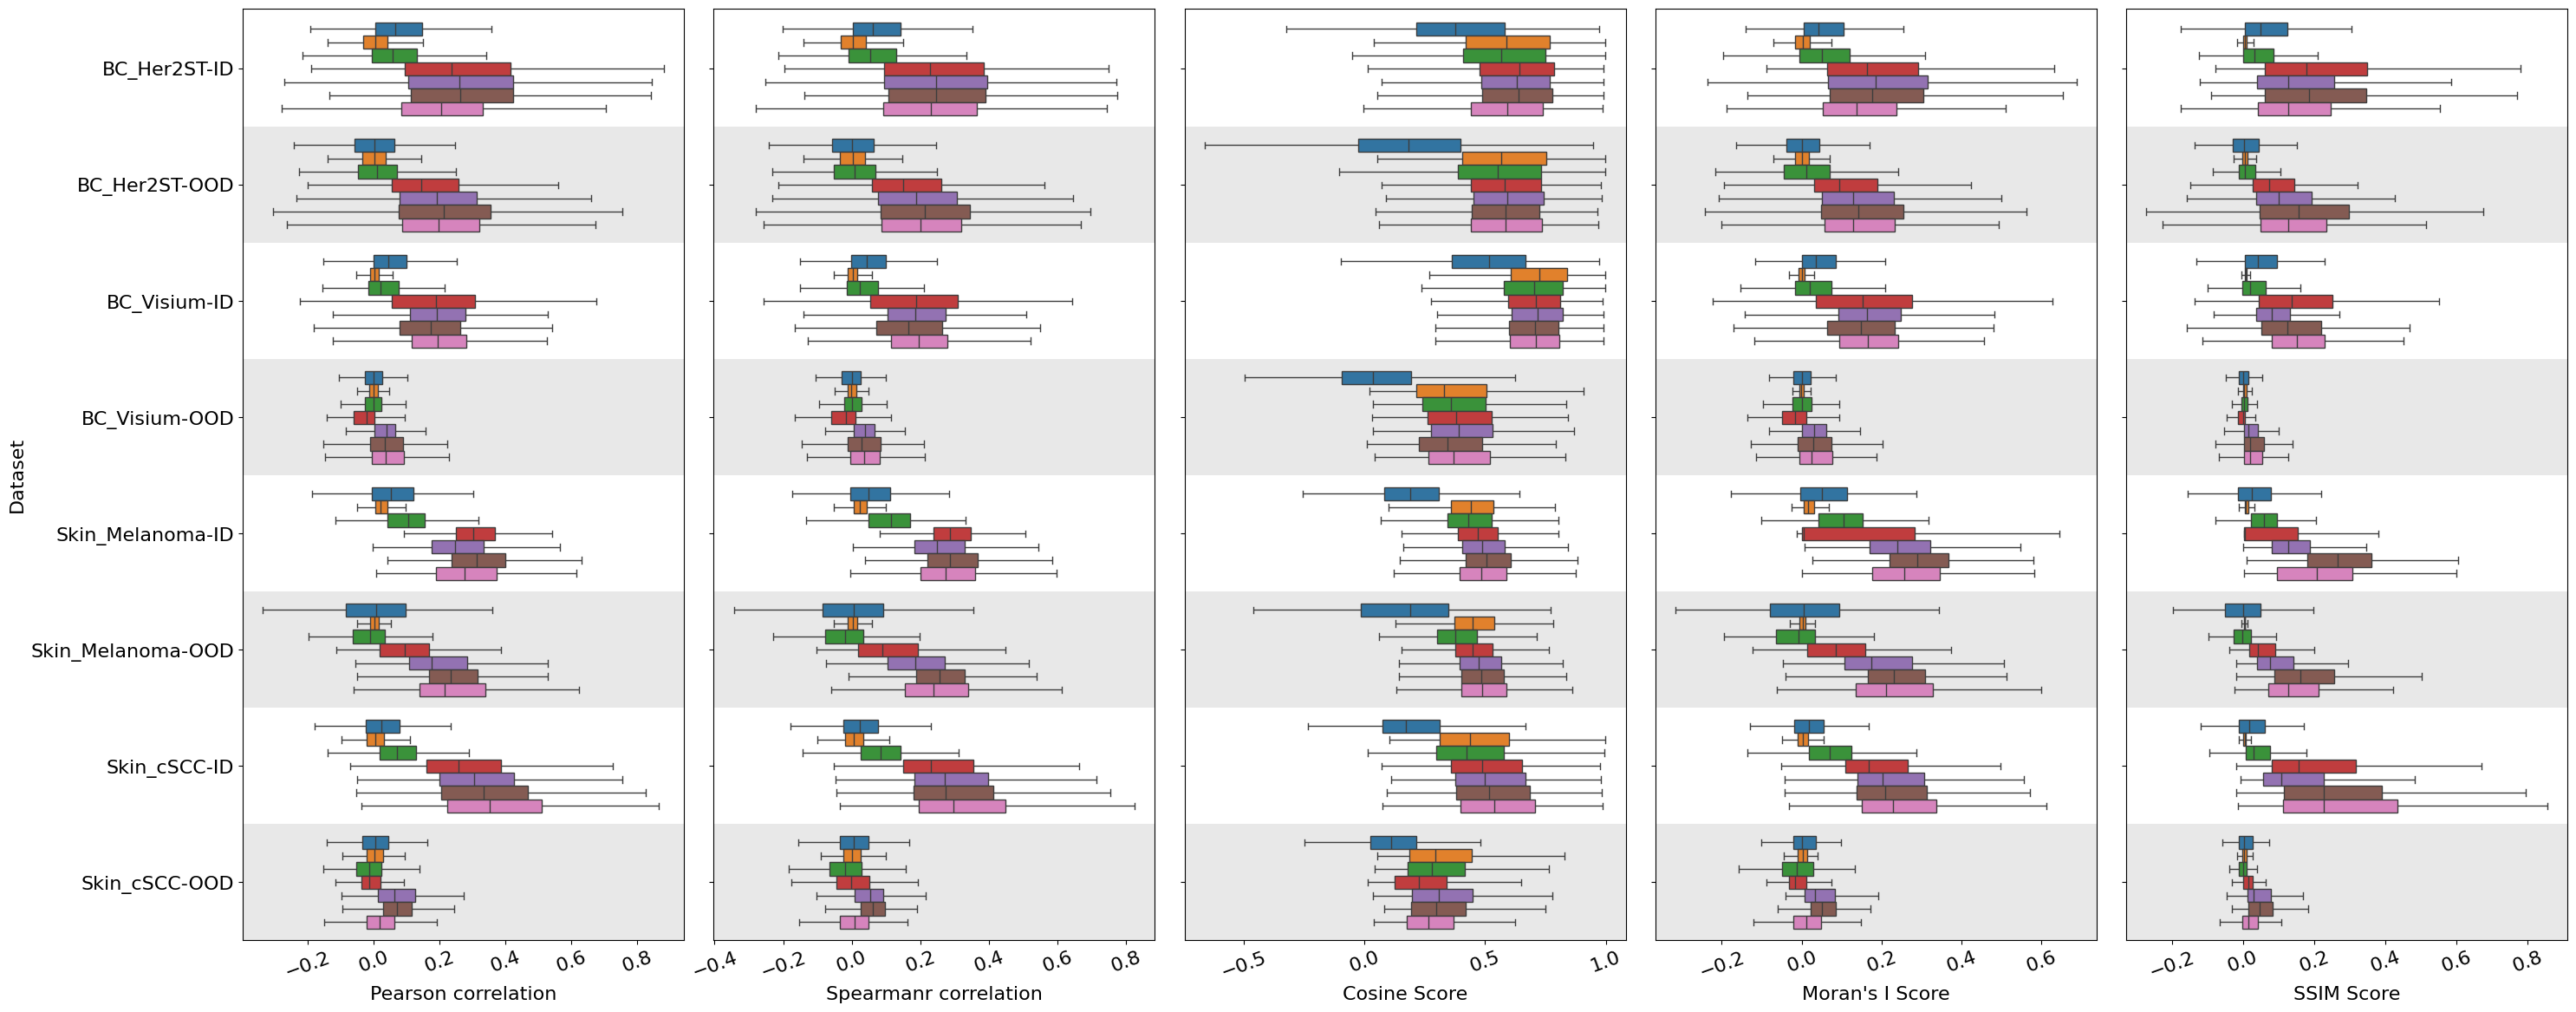

140

In [31]:
import matplotlib.pyplot as plt
# Collect garbage to free up memory
gc.collect()

# Set the font size for better readability
plt.rcParams.update({'font.size': 16})

# Create subplots with 4 rows and 1 column
fig, axs = plt.subplots(1, 5, figsize=(30, 12))

# List of columns and corresponding y-axis labels for plotting
columns_to_plot = [
    ('Pearson correlation', 'Pearson correlation', False),
    ('Spearmanr correlation', 'Spearmanr correlation', False),
    ('Cosine_Score', 'Cosine Score', False),
    ("Moran'I_Score", "Moran's I Score", False),
    ('SSIM_Score', 'SSIM Score', False),
]

# Loop through the columns and plot on the corresponding subplot
for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    sns.boxplot(x=column, y='Dataset', hue='Method', data=df_combined_predictable, ax=axs[i], showfliers=False)
    
    # Rotate x-axis labels with 10 degrees
    axs[i].tick_params(axis='x', labelrotation=20)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs[i].get_legend().remove()
    
    
    if i>0:
        axs[i].set_ylabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs[i].set_xlabel(ylabel)

for ax in axs[1:]:
    # ax.sharex(axs[0])
    ax.set_yticklabels([])
for ax in axs:
    ax.axhspan(0.5,1.5, facecolor='lightgray', alpha=0.5)
    ax.axhspan(2.5,3.5, facecolor='lightgray', alpha=0.5)
    ax.axhspan(4.5,5.5, facecolor='lightgray', alpha=0.5)
    ax.axhspan(6.5,7.5, facecolor='lightgray', alpha=0.5)
    set_ymargin(ax, left=0, right=0.015)


# Move the legend outside the plot area only for the first subplot
# pos = axs[0].get_position()
# axs[0].set_position([pos.x0, pos.y0, pos.width, pos.height * 1])
# axs[0].legend(
#     loc='upper center',
#     bbox_to_anchor=(0.5, 1.2),
#     ncol=7,
# )

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as a PDF file
# plt.savefig("Figure4.pdf")

# Show the plots
plt.show()

# Collect garbage to free up memory
gc.collect()


In [35]:
import pickle

with open('/scratch/user/uqjxie6/DeepHis2Exp/Figures/fighvgs.pkl', 'rb') as file:
    df_hvg = pickle.load(file)
# print(df_hvg.head())


In [33]:
with open('/scratch/user/uqjxie6/DeepHis2Exp/Figures/fig2_neww.pkl', 'rb') as file:
    df_combined_predictable_id = pickle.load(file)
# print(df_combined_predictable_id.head())


In [34]:
with open('/scratch/user/uqjxie6/DeepHis2Exp/Figures/fig1_firstpart.pkl', 'rb') as file:
    df_1 = pickle.load(file)
# print(df_1.head())


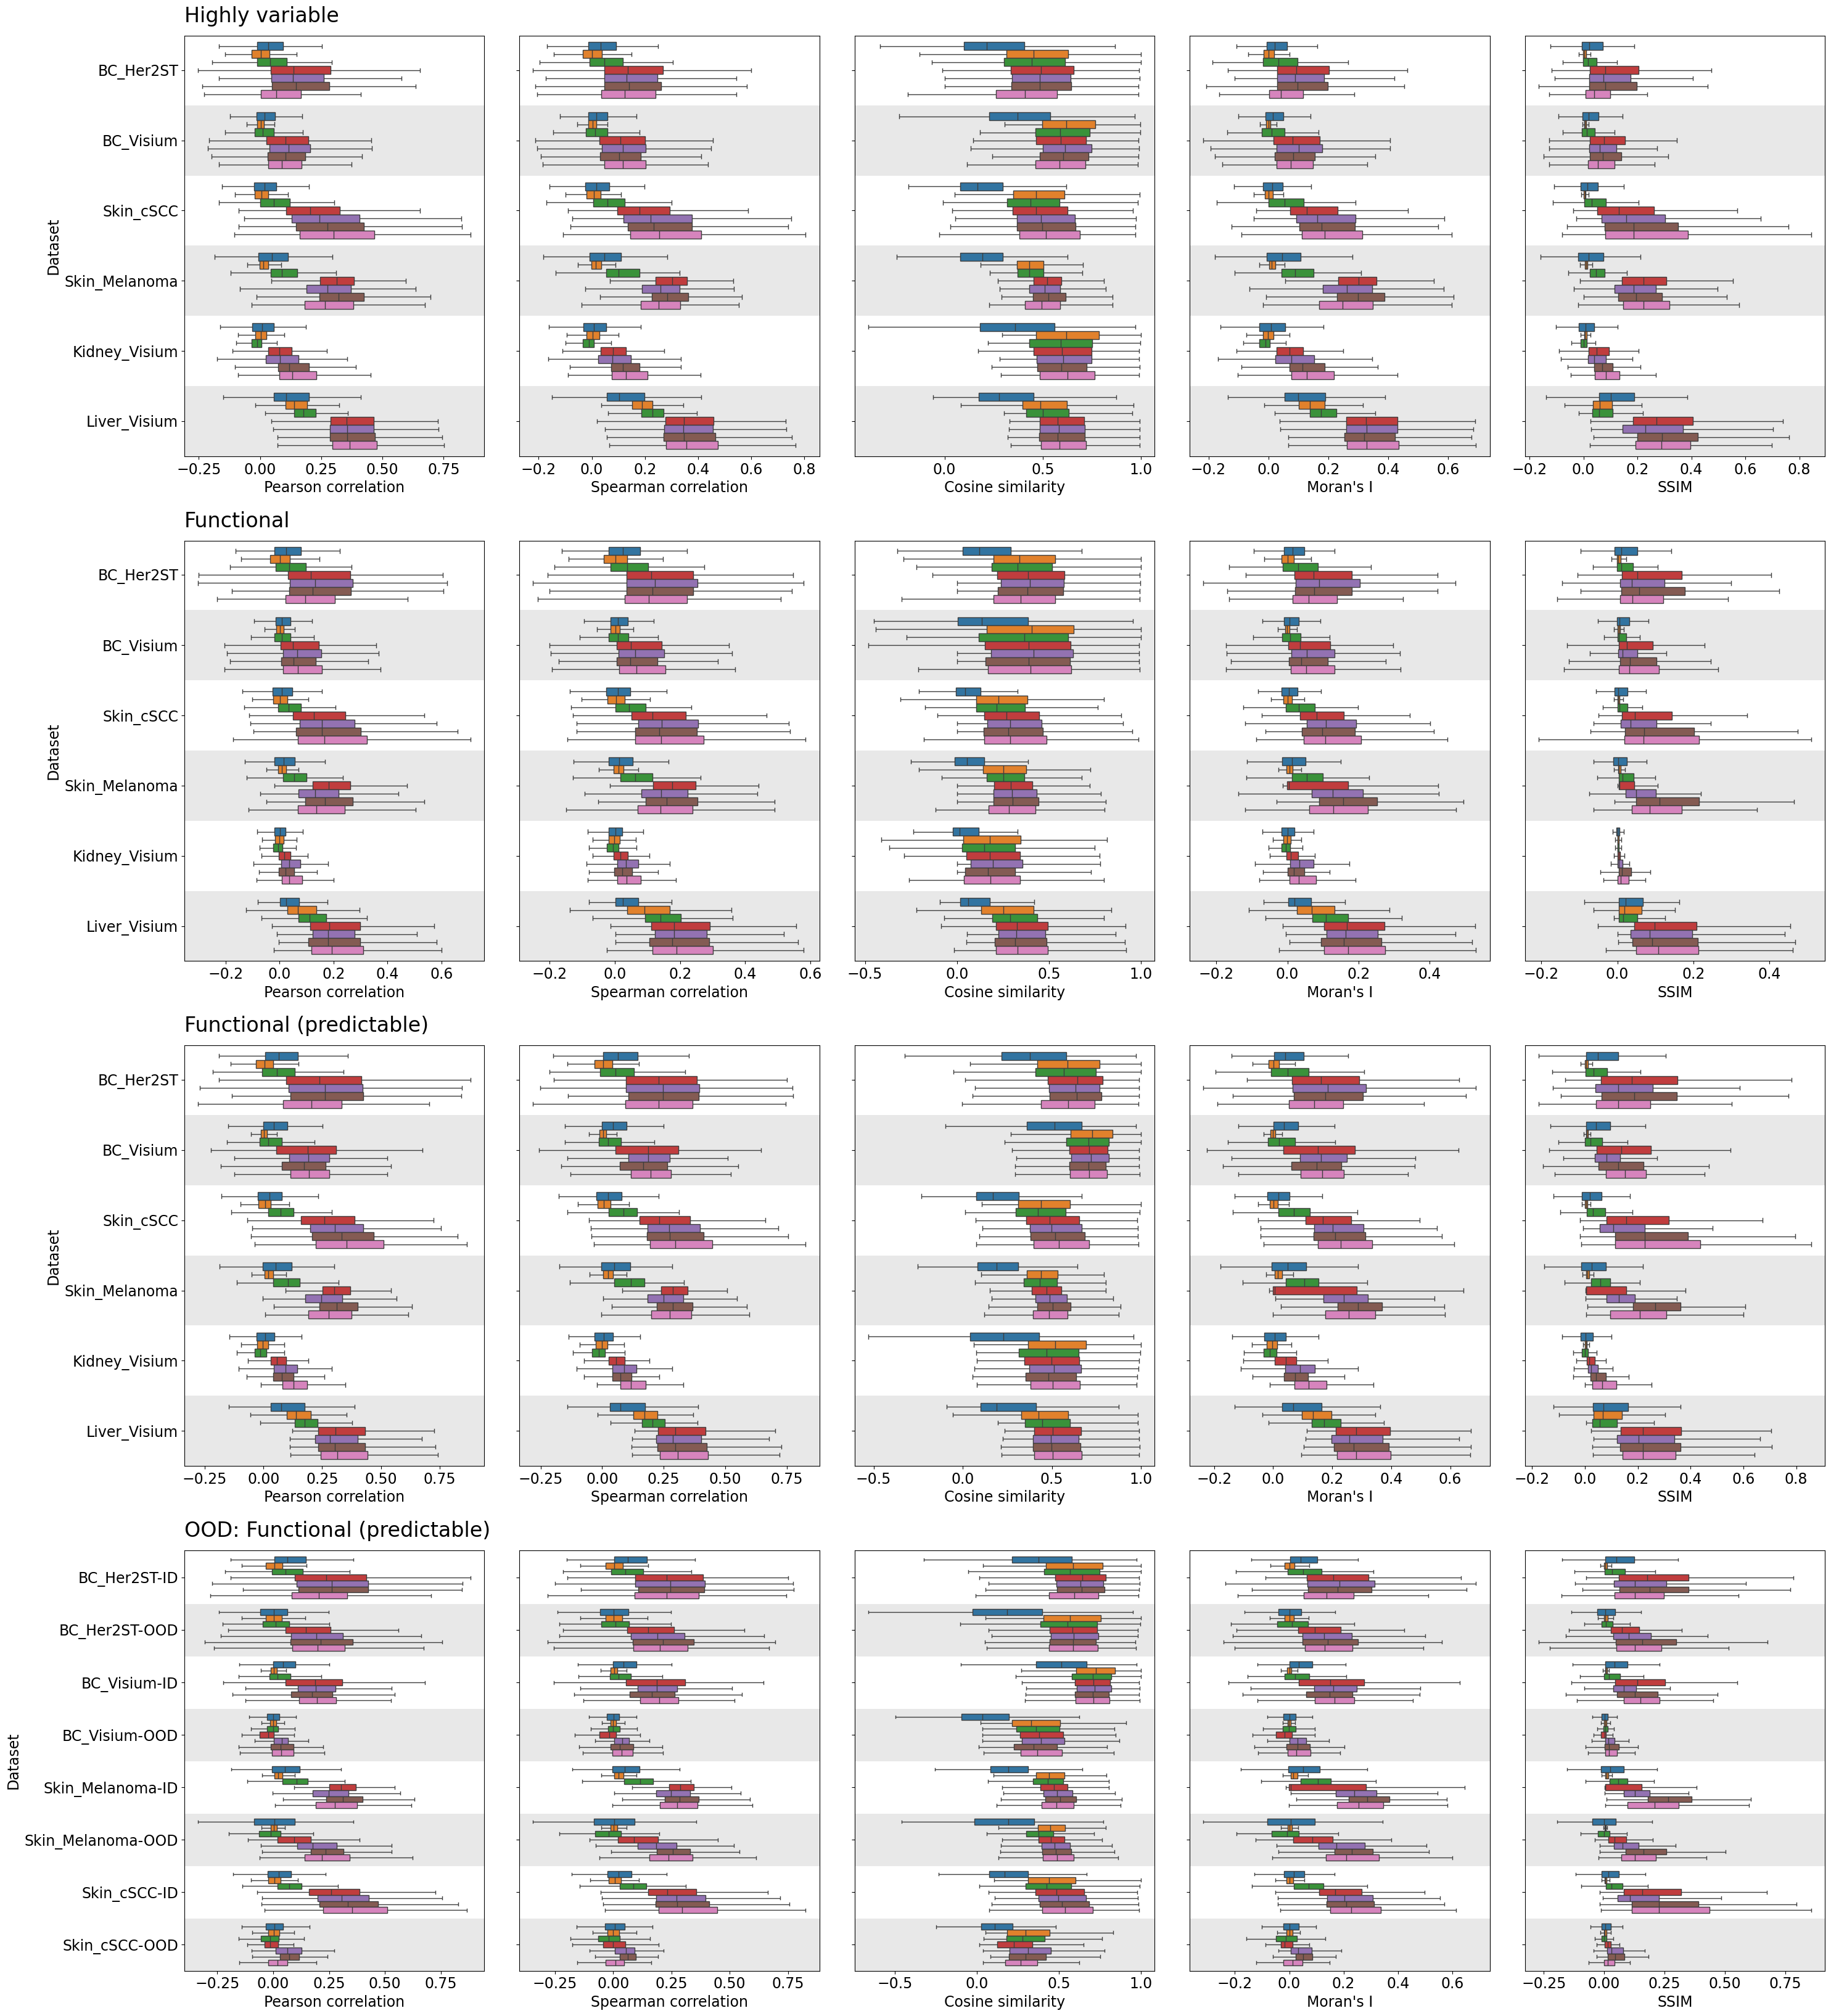

120

In [52]:
import matplotlib.pyplot as plt
# Collect garbage to free up memory
gc.collect()

# Set the font size for better readability
plt.rcParams.update({'font.size': 17})

# Create subplots with 4 rows and 1 column
fig, axs = plt.subplots(4, 5, figsize=(30, 33))

axs1 = axs[0]
axs2 = axs[1]
axs3 = axs[2]
axs4 = axs[3]

# List of columns and corresponding y-axis labels for plotting
columns_to_plot = [
    ('Pearson correlation', 'Pearson correlation', False),
    ('Spearmanr correlation', 'Spearman correlation', False),
    ('Cosine_Score', 'Cosine similarity', False),
    ("Moran'I_Score", "Moran's I", False),
    ('SSIM_Score', 'SSIM', False),
]

for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    # sns.boxplot(x='Dataset', y=column, hue='Method', data=df_combined_predictable, ax=axs[i], showfliers=False)
    sns.boxplot(x=column, y='Dataset', hue='Method', data=df_hvg, ax=axs1[i], showfliers=False)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs1[i].get_legend().remove()
    
    if i>0:
        axs1[i].set_ylabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs1[i].set_xlabel(ylabel)

for ax in axs1[1:]:
    # ax.sharex(axs[0])
    ax.set_yticklabels([])

for ax in axs1:
    ax.axhspan(0.5,1.5, facecolor='lightgray', alpha=0.5)
    ax.axhspan(2.5,3.5, facecolor='lightgray', alpha=0.5)
    ax.axhspan(4.5,5.5, facecolor='lightgray', alpha=0.5)
    set_ymargin(ax, left=0, right=0.015)

axs1[0].set_title("Highly variable", loc='left', pad=16, fontsize=24, weight='medium')

#############################

for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    # sns.boxplot(x='Dataset', y=column, hue='Method', data=df_combined_predictable, ax=axs[i], showfliers=False)
    sns.boxplot(x=column, y='Dataset', hue='Method', data=df_1, ax=axs2[i], showfliers=False)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs2[i].get_legend().remove()
    
    if i>0:
        axs2[i].set_ylabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs2[i].set_xlabel(ylabel)

for ax in axs2[1:]:
    # ax.sharex(axs[0])
    ax.set_yticklabels([])

for ax in axs2:
    ax.axhspan(0.5,1.5, facecolor='lightgray', alpha=0.5)
    ax.axhspan(2.5,3.5, facecolor='lightgray', alpha=0.5)
    ax.axhspan(4.5,5.5, facecolor='lightgray', alpha=0.5)
    set_ymargin(ax, left=0, right=0.015)

axs2[0].set_title("Functional", loc='left', pad=16, fontsize=24, weight='medium')

#############################

for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    sns.boxplot(x=column, y='Dataset', hue='Method', data=df_combined_predictable_id, ax=axs3[i], showfliers=False)
    
    # Rotate x-axis labels with 10 degrees
    # axs3[i].tick_params(axis='x', labelrotation=20)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs3[i].get_legend().remove()
    
    
    if i>0:
        axs3[i].set_ylabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs3[i].set_xlabel(ylabel)

for ax in axs3[1:]:
    # ax.sharex(axs[0])
    ax.set_yticklabels([])
for ax in axs3:
    ax.axhspan(0.5,1.5, facecolor='lightgray', alpha=0.5)
    ax.axhspan(2.5,3.5, facecolor='lightgray', alpha=0.5)
    ax.axhspan(4.5,5.5, facecolor='lightgray', alpha=0.5)
    set_ymargin(ax, left=0, right=0.015)

axs3[0].set_title("Functional (predictable)", loc='left', pad=16, fontsize=24, weight='medium')
#############################

for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    # sns.boxplot(x='Dataset', y=column, hue='Method', data=df_combined_predictable, ax=axs[i], showfliers=False)
    sns.boxplot(x=column, y='Dataset', hue='Method', data=df_combined_predictable, ax=axs4[i], showfliers=False)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs4[i].get_legend().remove()
    
    if i>0:
        axs4[i].set_ylabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs4[i].set_xlabel(ylabel)

for ax in axs4[1:]:
    # ax.sharex(axs[0])
    ax.set_yticklabels([])

for ax in axs4:
    ax.axhspan(0.5,1.5, facecolor='lightgray', alpha=0.5)
    ax.axhspan(2.5,3.5, facecolor='lightgray', alpha=0.5)
    ax.axhspan(4.5,5.5, facecolor='lightgray', alpha=0.5)
    ax.axhspan(6.5,7.5, facecolor='lightgray', alpha=0.5)
    set_ymargin(ax, left=0, right=0.015)

axs4[0].set_title("OOD: Functional (predictable)", loc='left', pad=16, fontsize=24, weight='medium')

#############################

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as a PDF file
plt.savefig("/scratch/user/uqjxie6/DeepHis2Exp/Figures/figcombb.png", bbox_inches='tight')

# Show the plots
plt.show()

# Collect garbage to free up memory
gc.collect()
